In [12]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
plt.rcParams['figure.figsize'] = (13, 5)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
features = utils.load('data/fma_metadata/DBMERGEfeatures.csv')

features.shape

(25000, 520)

In [3]:
features.head()

feature    metadata           chroma_cens                                \
statistics      set     track    kurtosis                                 
number       subset genre_top          01        02        03        04   
track_id                                                                  
2             small   Hip-Hop    7.180653  5.230309  0.249321  1.347620   
3            medium   Hip-Hop    1.888963  0.760539  0.345297  2.295201   
5             small   Hip-Hop    0.527563 -0.077654 -0.279610  0.685883   
10            small       Pop    3.702245 -0.291193  2.196742 -0.234449   
134          medium   Hip-Hop    0.918445  0.674147  0.577818  1.281117   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            05        06        07        08  ...        04        05   
track_id                                            ...                       
2           1.482478  0.531371  1.481593  2.691455  ...  0.054125  0.012226   
3           1.654031  0.067592  1.366848  1.054094  ...  0.063831  0.014212   
5           1.937570  0.880839 -0.923192 -0.927232  ...  0.040730  0.012691   
10          1.367364  0.998411  1.770694  1.604566  ...  0.074358  0.017952   
134         0.933746  0.078177  1.199204 -0.175223  ...  0.058766  0.016322   

feature                     zcr                                               \
statistics             kurtosis       max      mean    median  min      skew   
number            06         01        01        01        01   01        01   
track_id                                                                       
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.0  2.089872   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.0  1.716724   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.0  2.193303   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.0  3.542325   
134         0.015819   4.731087  0.419434  0.064370  0.050781  0.0  1.806106   

feature               
statistics       std  
number            01  
track_id              
2           0.061448  
3           0.069330  
5           0.044861  
10          0.040800  
134         0.054623  

[5 rows x 520 columns]

In [4]:
# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.50
to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]

# Drop features 
features.drop(to_drop, axis=1, inplace=True)

In [5]:

# creating instance of labelencoder
le = LabelEncoder()
features[('metadata','track','genre_top_Cat')] = le.fit_transform(features[('metadata','track','genre_top')])



In [6]:
features.head()

feature    metadata           chroma_cens                                \
statistics      set     track    kurtosis                                 
number       subset genre_top          01        02        03        04   
track_id                                                                  
2             small   Hip-Hop    7.180653  5.230309  0.249321  1.347620   
3            medium   Hip-Hop    1.888963  0.760539  0.345297  2.295201   
5             small   Hip-Hop    0.527563 -0.077654 -0.279610  0.685883   
10            small       Pop    3.702245 -0.291193  2.196742 -0.234449   
134          medium   Hip-Hop    0.918445  0.674147  0.577818  1.281117   

feature                                             ...   tonnetz            \
statistics                                          ...       min      skew   
number            05        06        07        08  ...        06        01   
track_id                                            ...                       
2           1.482478  0.531371  1.481593  2.691455  ... -0.089286  0.752462   
3           1.654031  0.067592  1.366848  1.054094  ... -0.055667  0.265541   
5           1.937570  0.880839 -0.923192 -0.927232  ... -0.146136  1.212025   
10          1.367364  0.998411  1.770694  1.604566  ... -0.029836 -0.135219   
134         0.933746  0.078177  1.199204 -0.175223  ... -0.053569  0.927807   

feature                                                                 \
statistics                                                         std   
number            02        03        04        05        06        01   
track_id                                                                 
2           0.262607  0.200944  0.593595 -0.177665 -1.424201  0.019809   
3          -0.131471  0.171930 -0.990710  0.574556  0.556494  0.026316   
5           0.218381 -0.419971 -0.014541 -0.199314 -0.925733  0.025550   
10         -0.275780  0.015767 -1.094873  1.164041  0.246746  0.021413   
134        -0.947771  0.143864 -0.529867  0.162188  0.063846  0.024258   

feature           zcr      metadata  
statistics   kurtosis         track  
number             01 genre_top_Cat  
track_id                             
2            5.758890             7  
3            2.824694             7  
5            6.808415             7  
10          21.434212            12  
134          4.731087             7  

[5 rows x 194 columns]

In [7]:

attributes = [col for col in features.columns if (col != ('metadata','track','genre_top') and 
                                                  col != ('metadata','set','subset')  and
                                                 col != ('metadata','track','genre_top_Cat'))] 

X = features[attributes].values
y = features[('metadata','track','genre_top_Cat')]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


In [15]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [23]:
param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split' : range(30,80,10),
              'min_samples_leaf' : range(30,80,10),
              'max_depth': range(8, 20, 3),
             'class_weight':['balanced','balanced_subsample'],
             'max_features':[20],
              'n_estimators':[100]
             }


clf1 = RandomizedSearchCV(RandomForestClassifier(), 
                         param_grid, cv=StratifiedKFold(3), scoring='f1_macro',n_iter=15)

clf1 = clf1.fit(X_train, y_train)
report(clf1.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.361 (std: 0.005)
Parameters: {'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 30, 'max_features': 20, 'max_depth': 14, 'criterion': 'gini', 'class_weight': 'balanced'}

Model with rank: 2
Mean validation score: 0.359 (std: 0.002)
Parameters: {'n_estimators': 100, 'min_samples_split': 60, 'min_samples_leaf': 30, 'max_features': 20, 'max_depth': 14, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}

Model with rank: 3
Mean validation score: 0.349 (std: 0.003)
Parameters: {'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 40, 'max_features': 20, 'max_depth': 17, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}

Model with rank: 4
Mean validation score: 0.348 (std: 0.003)
Parameters: {'n_estimators': 100, 'min_samples_split': 70, 'min_samples_leaf': 40, 'max_features': 20, 'max_depth': 17, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}

Model with rank: 5
Mean validation score: 0

In [24]:
clf1 = RandomForestClassifier(criterion='gini', max_depth=14, min_samples_split=30, min_samples_leaf=30,class_weight="balanced",
                             max_features=20,random_state=0,n_estimators=100)
clf1 = clf1.fit(X_train, y_train)

In [25]:
y_pred_tr = clf1.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='macro'))
print('Val Recall %s' % recall_score(y_train, y_pred_tr,average='macro'))
print('Val Precision %s' % precision_score(y_train, y_pred_tr,average='macro'))

print(classification_report(y_train, y_pred_tr))

confusion_matrix(y_train, y_pred_tr)


Train Accuracy 0.6552
Train F1-score 0.6706044433610253
Val Recall 0.8077185808490412
Val Precision 0.6141220476735396
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        52
           1       0.52      0.94      0.67       433
           2       0.63      0.98      0.76       124
           3       0.75      1.00      0.86        15
           4       0.84      0.49      0.62      4420
           5       0.71      0.35      0.47      1576
           6       0.57      0.80      0.66      1063
           7       0.50      0.87      0.63      1541
           8       0.48      0.64      0.55       945
           9       0.61      0.67      0.64       713
          10       0.43      0.90      0.58       269
          11       0.71      0.99      0.83       357
          12       0.53      0.55      0.54       830
          13       0.81      0.73      0.77      4972
          14       0.64      1.00      0.78       108
          15    

array([[  52,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,  409,    0,    0,    1,    0,    4,    2,    4,    1,    6,
           2,    2,    0,    1,    1],
       [   0,    0,  122,    0,    0,    0,    0,    0,    1,    0,    0,
           0,    0,    0,    0,    1],
       [   0,    0,    0,   15,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   7,   92,   15,    3, 2184,  123,  126,  806,  255,  100,   75,
          32,  150,  375,   43,   34],
       [   3,   93,    6,    0,  116,  548,   98,  132,  150,   52,   74,
          49,   37,  166,    6,   46],
       [   0,   17,    6,    0,    4,    9,  849,   24,   42,   12,   18,
          10,    8,   58,    1,    5],
       [   0,    0,    0,    0,   47,    4,   16, 1347,   12,   15,    4,
           2,   15,   53,    1,   25],
       [   1,   97,    0,    1,   36,   23,   28,   21,  609,    9,   19,
          16,   20,   

In [26]:
y_pred = clf1.predict(X_test)

print('Val Accuracy %0.4f' % accuracy_score(y_test, y_pred))


print('Train F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print('Val Recall %s' % recall_score(y_test, y_pred,average='macro'))
print('Val Precision %s' % precision_score(y_test, y_pred,average='macro'))

print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

Val Accuracy 0.5285
Train F1-score 0.38030251241022706
Val Recall 0.4561379909438138
Val Precision 0.36471002040485334
              precision    recall  f1-score   support

           0       0.20      0.14      0.16        22
           1       0.45      0.84      0.58       186
           2       0.25      0.37      0.30        54
           3       0.00      0.00      0.00         6
           4       0.74      0.41      0.53      1894
           5       0.50      0.17      0.25       675
           6       0.45      0.67      0.54       456
           7       0.39      0.74      0.51       660
           8       0.33      0.43      0.38       405
           9       0.39      0.40      0.40       305
          10       0.19      0.42      0.26       115
          11       0.63      0.99      0.77       153
          12       0.19      0.15      0.17       356
          13       0.74      0.71      0.72      2131
          14       0.17      0.20      0.18        46
          15    

array([[   3,    2,    0,    0,    2,    2,    2,    3,    0,    0,    3,
           0,    1,    2,    1,    1],
       [   0,  156,    0,    0,    1,    1,    7,    0,   12,    1,    7,
           0,    0,    0,    0,    1],
       [   0,    0,   20,    0,    1,    1,    5,    3,    0,    4,    3,
           1,    2,   14,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    3,    1,    1,    1,
           0,    0,    0,    0,    0],
       [   1,   38,    5,    1,  786,   50,   52,  433,  119,   40,   49,
          14,   77,  193,   22,   14],
       [   2,   45,    3,    1,   65,  115,   40,   65,   86,   23,   43,
          33,   15,  108,    2,   29],
       [   0,   11,    4,    0,    4,    1,  304,   13,   34,   25,   10,
           6,   15,   25,    2,    2],
       [   0,    1,    1,    1,   64,    4,    9,  491,    7,   13,    4,
           1,   14,   42,    5,    3],
       [   1,   58,    0,    0,   16,   13,   47,    9,  176,    7,   28,
          11,   10,   

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[   3    2    0    0    2    2    2    3    0    0    3    0    1    2
     1    1]
 [   0  156    0    0    1    1    7    0   12    1    7    0    0    0
     0    1]
 [   0    0   20    0    1    1    5    3    0    4    3    1    2   14
     0    0]
 [   0    0    0    0    0    0    0    3    1    1    1    0    0    0
     0    0]
 [   1   38    5    1  786   50   52  433  119   40   49   14   77  193
    22   14]
 [   2   45    3    1   65  115   40   65   86   23   43   33   15  108
     2   29]
 [   0   11    4    0    4    1  304   13   34   25   10    6   15   25
     2    2]
 [   0    1    1    1   64    4    9  491    7   13    4    1   14   42
     5    3]
 [   1   58    0    0   16   13   47    9  176    7   28   11   10   27
     1    1]
 [   0    6    3    0   30    3   20   61    2  122   10    6    9   18
     2   13]
 [   0   18    1    0    1    0    8    5   13    6   48    2    3   10
     0    0]
 [   0    1    0    0    

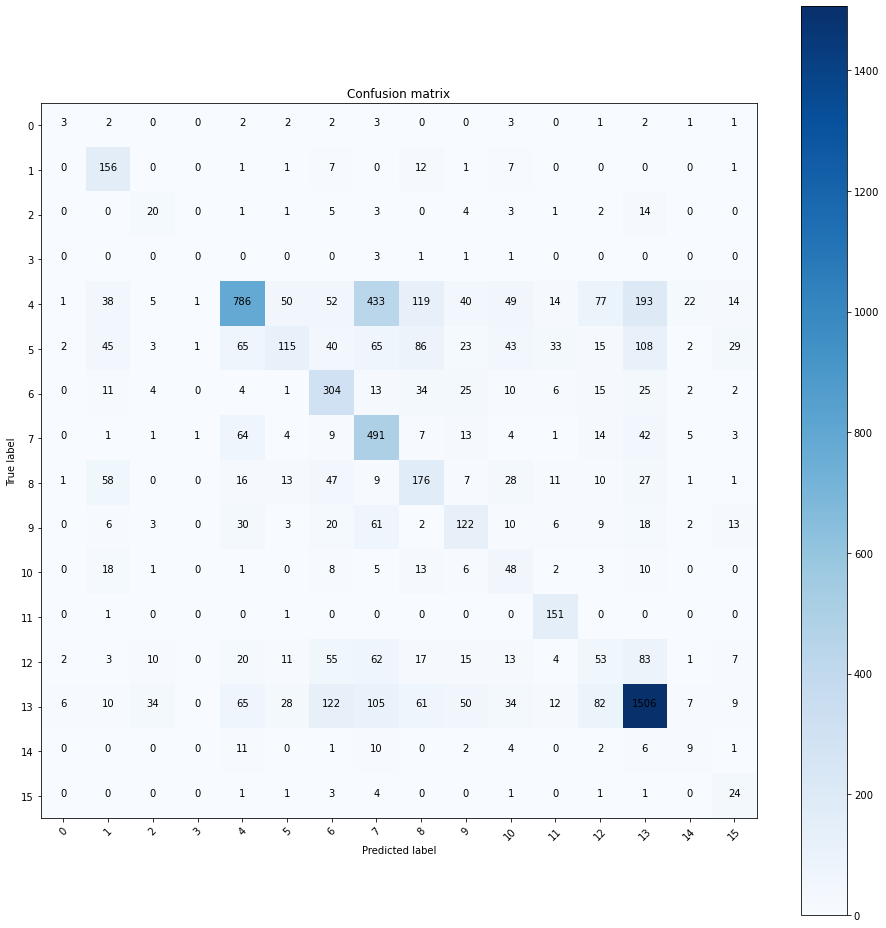

In [28]:
plt.rcParams['figure.figsize'] = (13, 13)

cm1=confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm1, classes=clf1.classes_,
                      title='Confusion matrix')



plt.show()